## Initial EDA

The eventual plan is to process the CDC WONDER file to a point where you can query it for any (major) cause of death, and the program goes off and calculates its forecast for you, but we'll start off small. I went and got the deaths from myocardial infarction per state per month, from 1999 to 2016. We'll go ahead and start modeling off of these time series.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (12,8)

In [3]:
%%bash
ls ../data

Californiabysex.xlsx
OB_PREV_ALL_STATES.xlsx
brfss
california_MI_mortality.txt
cdc_diabetes
cdc_wonder
laucnty17.txt
mort2016.csv
mort2016.csv.zip
mort2016us.zip
myocardial_infarction.txt
pickles
total_cardiovascular_disease_2014_16.csv
unemployment


In [4]:
with open("../data/myocardial_infarction.txt", "r") as f:
    lines = [line.rstrip('\n') for line in f]

In [5]:
lines = [line.replace('"', '') for line in lines]

In [6]:
split_lines = [line.split("\t") for line in lines]

In [7]:
df = pd.DataFrame(data=split_lines[1:], columns=split_lines[0])

In [8]:
df.head()

,Notes,State,State Code,Month,Month Code,Deaths,Population,Crude Rate
0,,Alabama,01,"Jan., 1999",1999/01,332,Not Applicable,Not Applicable
1,,Alabama,01,"Feb., 1999",1999/02,332,Not Applicable,Not Applicable
2,,Alabama,01,"Mar., 1999",1999/03,377,Not Applicable,Not Applicable
3,,Alabama,01,"Apr., 1999",1999/04,301,Not Applicable,Not Applicable
4,,Alabama,01,"May, 1999",1999/05,314,Not Applicable,Not Applicable


In [9]:
df['Month'] = pd.to_datetime(df['Month'])

In [10]:
df['Deaths'] = pd.to_numeric(df['Deaths'], errors='coerce')

In [11]:
deaths_grouped_state = df.groupby(['State'])[['Month', 'Deaths']]

In [12]:
state_mortality_dict = {}

In [13]:
for state in deaths_grouped_state.groups.keys():
    state_mortality_dict[state] = deaths_grouped_state.get_group(state).set_index('Month')

In [14]:
state_list = list(deaths_grouped_state.groups.keys())

In [15]:
state_mortality_dict['California'].index

DatetimeIndex(['1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01',
               '1999-05-01', '1999-06-01', '1999-07-01', '1999-08-01',
               '1999-09-01', '1999-10-01',
               ...
               '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01',
               '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01',
               '2016-11-01', '2016-12-01'],
              dtype='datetime64[ns]', name='Month', length=216, freq=None)

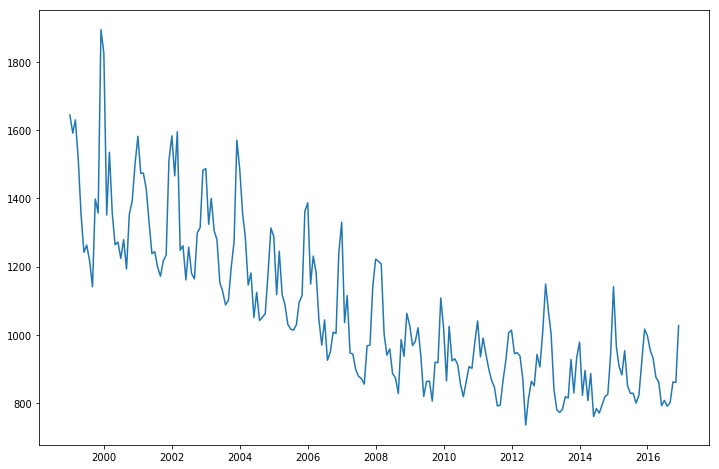

In [16]:
plt.plot(state_mortality_dict['California'].index, state_mortality_dict['California'])
plt.show()

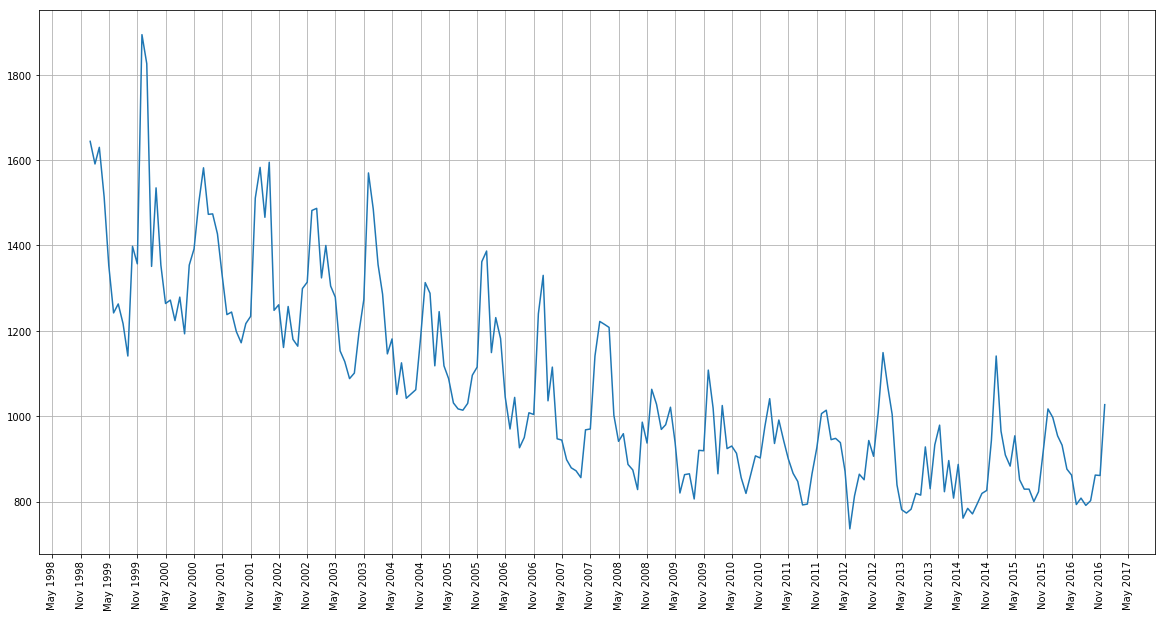

In [17]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)  
plt.plot(state_mortality_dict['California'].index, state_mortality_dict['California'])
plt.xticks(rotation=90)
plt.grid()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

## ARMA and ARIMA

Okay, so let's go ahead and try to apply the techniques that we learned in class to forecast the deaths due to myocardial infarct in California from 1999 to 2016. We can then plot the other states later; we're also going to have to correct for the state population, which is going to mean reading in the state populations either from the US census or some other source, e.g. [federal reserve of st. louis](https://fred.stlouisfed.org/release/tables?rid=118&eid=259194)

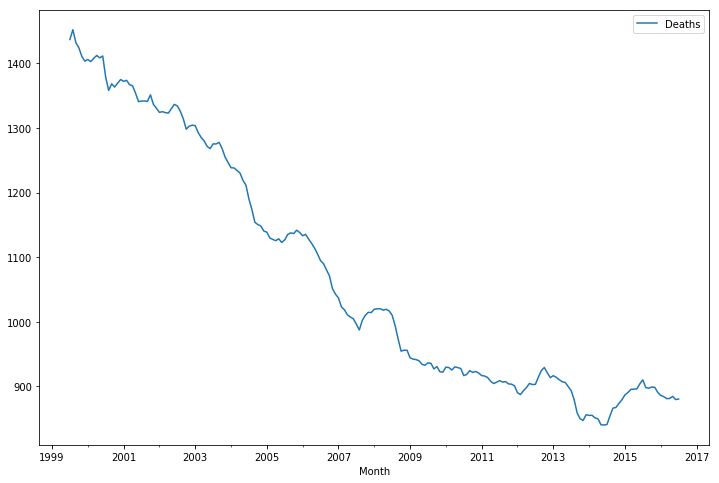

In [18]:
state_mortality_dict['California'].rolling(window=12, center=True).mean().plot()

We'll go ahead and use the tutorial [here](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3) by digital ocean. We'll go ahead and test it out using California first.

In [19]:
california = state_mortality_dict['California']

In [20]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [21]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA:')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA:
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [22]:
len(pdq)

27

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
sarima_gridsearch = []
i = 0

for param in pdq:
    print(i)
    i += 1
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(california,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            sarima_gridsearch.append((param, param_seasonal, results.aic))
        except:
            continue

0
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3622.5626104772527
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3169.400686009511
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:2983.6226469560197
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2421.772159556879
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2243.8033957895996
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:2088.7359275621857
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:2447.8001811185286
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:2123.3591452038727
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:1940.3725089994878
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2399.9763476611815
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2328.465541692337
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:2176.492136231647
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2255.0630597045565
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2240.0739745803007
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:2059.2407621227803
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:2172.844782534145
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:2090.135916494407
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:1946.2788859024

ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:2081.7651540208117
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:1932.9652246389098
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:2147.152479783905
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:2008.7563516823325
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:1848.054686145786
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:2122.2981105124213
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:2092.908694720794
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:2043.7271706858683
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:1990.9615218713357
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:1977.7137635744257
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:1934.7864729976354
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:1957.5494682197714
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:1896.4921249099154
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:1845.410142164798
6
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:2780.5214322860147
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:2535.8620289284936
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:2364.5664468879354
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:2600.52580813

ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:1886.682342077354
11
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:2608.0224993967063
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:2353.381984366032
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:2298.1114024613307
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:2346.5543395005084
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:2093.520822622768
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:1948.5506712502922
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:2390.686814760205
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:2062.2141839989163
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:1864.4896156003115
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:2365.907715828692
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:2220.755642308465
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:2065.172998644226
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:2142.732942739349
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:2094.0655236166504
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:1947.9492180594377
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:2143.2310298479097
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:2026.17646207371

ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:2162.756945847904
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:2118.075525080388
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:1964.2564087373548
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:2179.334330748756
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:2054.3489049738437
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:1881.4498944836846
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:2140.9561027808304
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:2108.815813644107
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:2087.7006581667824
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:2009.2387237155745
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:1991.6683512135655
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:1966.7263697739932
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:1977.9051167351677
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:1913.7166659589916
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:1881.3055842313984
17
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:2589.5603040587594
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:2317.6357832540334
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:2151.3554316

In [ ]:
sarima_gridsearch.sort(key=lambda x: x[2])

In [28]:
sarima_gridsearch[0:5]

[((1, 2, 2), (0, 2, 2, 12), 1838.8125602055256),
 ((0, 1, 2), (2, 2, 2, 12), 1845.410142164798),
 ((0, 1, 2), (1, 2, 2, 12), 1848.054686145786),
 ((1, 1, 2), (1, 2, 2, 12), 1848.9442128262037),
 ((0, 1, 2), (0, 2, 2, 12), 1849.810120079564)]

In [31]:
test = california.groupby(by=[california.index.year])

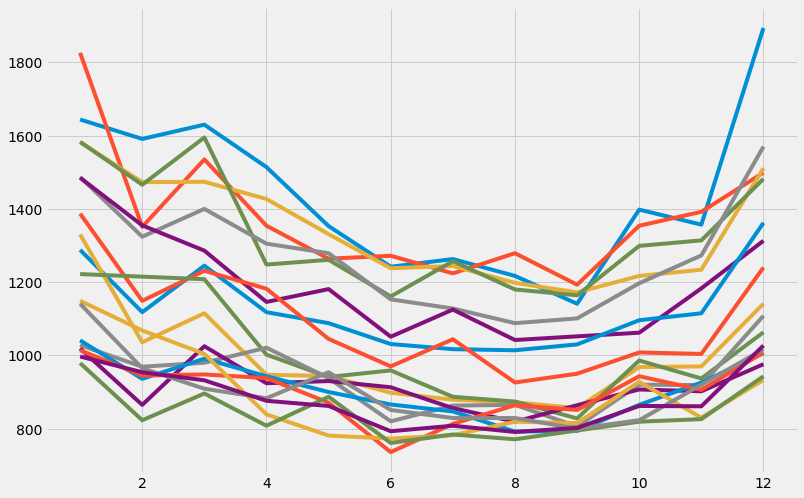

In [35]:
for group in test.groups:
    plt.plot(test.get_group(group).index.month, test.get_group(group))